In [1]:
import pandas as pd
import matplotlib.pyplot as plt

#reading the provided csv into a dataframe 'df'
df = pd.read_csv('events_log.csv', delimiter = ',', quotechar= "'",
    dtype = {"uuid":str, "timestamp":str, "session_id" : str, "group":str, "action":str, "checkin":str, "page_id":str, "n_results":str, "result_position":str })
pd.set_option('display.expand_frame_repr', False)

#filling df with only the timestamp that have numeric values to clean out dates like 2.0160301..
df = df[df.timestamp.apply(lambda x: x.isnumeric())]
print(df.head())

                               uuid       timestamp        session_id group            action checkin           page_id n_results result_position
0  00000736167c507e8ec225bd9e71f9e5  20160301103842  78245c2c3fba013a     b  searchResultPage     NaN  cbeb66d1bc1f1bc2         5             NaN
1  00000c69fe345268935463abbfa5d5b3  20160307005226  c559c3be98dca8a4     a  searchResultPage     NaN  eb658e8722aad674        10             NaN
2  00003bfdab715ee59077a3670331b787  20160302145305  760bf89817ce4b08     a           checkin      30  f99a9fc1f7fdd21e       NaN             NaN
3  0000465cd7c35ad2bdeafec953e08c1a  20160302222701  fb905603d31b2071     a           checkin      60  e5626962a6939a75       NaN              10
4  000050cbb4ef5b42b16c4d2cf69e6358  20160302095023  c2bf5e5172a892dc     a           checkin      30  787dd6a4c371cbf9       NaN             NaN


In [2]:
#to see all the distinct values present in the columns and look for discrepencies
df_check_unique = df['action'].unique()
df_check_unique

array(['searchResultPage', 'checkin', 'visitPage'], dtype=object)

In [3]:
# to see all the columns and rows when we do fetchall()
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [4]:
#to get only the date part from the timestamp and storing it as a new column in df
df['datepart_timestamp'] = df['timestamp'].str[:8]

#to get only the hour part from the timestamp and storing it as a new column in df
df['datehourpart_timestamp'] = df['timestamp'].str[8:10]
df.head()

,uuid,timestamp,session_id,group,action,checkin,page_id,n_results,result_position,datepart_timestamp,datehourpart_timestamp
0,00000736167c507e8ec225bd9e71f9e5,20160301103842,78245c2c3fba013a,b,searchResultPage,NaN,cbeb66d1bc1f1bc2,5,NaN,20160301,10
1,00000c69fe345268935463abbfa5d5b3,20160307005226,c559c3be98dca8a4,a,searchResultPage,NaN,eb658e8722aad674,10,NaN,20160307,00
2,00003bfdab715ee59077a3670331b787,20160302145305,760bf89817ce4b08,a,checkin,30,f99a9fc1f7fdd21e,NaN,NaN,20160302,14
3,0000465cd7c35ad2bdeafec953e08c1a,20160302222701,fb905603d31b2071,a,checkin,60,e5626962a6939a75,NaN,10,20160302,22
4,000050cbb4ef5b42b16c4d2cf69e6358,20160302095023,c2bf5e5172a892dc,a,checkin,30,787dd6a4c371cbf9,NaN,NaN,20160302,09


In [5]:
#creating a new df with only searchResultPage values 
df_searchPages = df.query('action=="searchResultPage"')
#df_total_searches = df_total_searches.agg({"session_id":"nunique"})
# df_total_searches = df_total_searches.agg(session_sp=("session_id","nunique"))

#grouping by daily and group(a,b) and then counting the unique sessions for each of them and storing the count in a new column
df_total_searches = df_searchPages.groupby(['datepart_timestamp','group'])['session_id'].agg([('session_sp','nunique')])
df_total_searches.head()

session_sp
datepart_timestamp group            
20160301           a            4208
                   b            5036
20160302           a            4215
                   b            4983
20160303           a            4202

In [6]:
#creating a new df with only visitPage values where it doesn't have a null result_position (assuming that all the visitPage will have a result_position)
df_visitpages = df.query('action=="visitPage"&result_position==result_position')

#grouping by daily and group(a,b) and then counting the unique sessions for each of them and storing the count in a new column
df_total_visitpages = df_visitpages.groupby(['datepart_timestamp','group'])['session_id'].agg([('session_vp','nunique')])
df_total_visitpages.head()

session_vp
datepart_timestamp group            
20160301           a            2825
                   b             697
20160302           a            2875
                   b             725
20160303           a            2844

In [7]:
#creating a new df with only searchResultPage values where it yielded 0 or null results
df_zeroyieldpages = df.query('action=="searchResultPage"& (n_results=="0"|n_results=="NA")')

#grouping by daily and group(a,b) and then counting the unique sessions for each of them and storing the count in a new column
df_total_zeroyieldpages = df_zeroyieldpages.groupby(['datepart_timestamp','group'])['session_id'].agg([('session_zyp','nunique')])
df_total_zeroyieldpages.head()

session_zyp
datepart_timestamp group             
20160301           a              945
                   b              998
20160302           a              971
                   b              966
20160303           a              937

In [8]:
#for finding the most clicked result
#grouping the visitpages by date,group and the clicked result and then getting total counts for each result position
df_count_clickedresults = df_visitpages.groupby(['datepart_timestamp','group','result_position'])['result_position'].agg([('total_click_count','count')])

#finding the max from that count to find the most clicked result
idx = df_count_clickedresults.groupby(['datepart_timestamp','group'])['total_click_count'].transform(max) == df_count_clickedresults['total_click_count']
df_most_clicked_result = df_count_clickedresults[idx].reset_index()
df_most_clicked_result.head()

,datepart_timestamp,group,result_position,total_click_count
0,20160301,a,1,2348
1,20160301,b,1,477
2,20160302,a,1,2356
3,20160302,b,1,498
4,20160303,a,1,2480


In [9]:
#concating and merging all the datasets together so we can answer Ques 1, Ques 2 and Ques 3 from one table
result = pd.concat([df_total_searches, df_total_visitpages, df_total_zeroyieldpages], axis=1).reset_index()

#we had to merge this dataframe separately as the shapes of these two df's are not the same
final_result = pd.merge(result,df_most_clicked_result, on = ['datepart_timestamp','group'])
result.head()
final_result.head()

,datepart_timestamp,group,session_sp,session_vp,session_zyp,result_position,total_click_count
0,20160301,a,4208,2825,945,1,2348
1,20160301,b,5036,697,998,1,477
2,20160302,a,4215,2875,971,1,2356
3,20160302,b,4983,725,966,1,498
4,20160303,a,4202,2844,937,1,2480


In [10]:
#finding the clickthrough rate by dividing the number of sessions where atleast one result was clicked , by the total number of sessions
final_result['clickthroughrate'] = final_result['session_vp']*100/final_result['session_sp']
final_result['clickthroughrate'] = final_result['clickthroughrate'].round(2)

#finding the clickthrough rate by dividing the number of sessions where the searches yielded 0 or null , by the total number of sessions
final_result['zeroyield'] = final_result['session_zyp']*100/final_result['session_sp']
final_result['zeroyield'] = final_result['zeroyield'].round(2)

In [11]:
#Report for clickthroughrate, zeroyield and the most clicked result on a daily basis
final_result_1 = final_result[['datepart_timestamp','group','clickthroughrate','zeroyield','result_position']]
final_result_1

,datepart_timestamp,group,clickthroughrate,zeroyield,result_position
0,20160301,a,67.13,22.46,1
1,20160301,b,13.84,19.82,1
2,20160302,a,68.21,23.04,1
3,20160302,b,14.55,19.39,1
4,20160303,a,67.68,22.30,1
5,20160303,b,15.20,18.71,1
6,20160304,a,67.58,22.54,1
7,20160304,b,19.31,18.02,1
8,20160305,a,64.62,24.10,1
9,20160305,b,20.26,20.46,1


In [12]:
#pivoting the table to get plot the graphs based on dates and groups
result_ab = final_result.pivot(index='datepart_timestamp', columns='group', values=['clickthroughrate','zeroyield','result_position']).reset_index()
result_ab.head()

datepart_timestamp clickthroughrate        zeroyield        result_position   
group                                   a      b         a      b               a  b
0               20160301            67.13  13.84     22.46  19.82               1  1
1               20160302            68.21  14.55     23.04  19.39               1  1
2               20160303            67.68   15.2      22.3  18.71               1  1
3               20160304            67.58  19.31     22.54  18.02               1  1
4               20160305            64.62  20.26      24.1  20.46               1  1

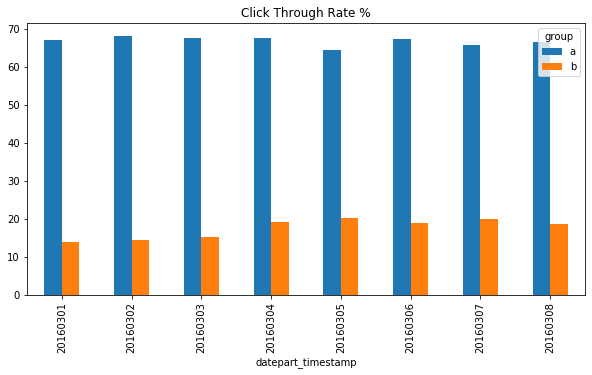

In [13]:
#Plotting the graph for clickthroughrate
result_ab.plot(kind='bar',x='datepart_timestamp',y='clickthroughrate', title='Click Through Rate %', figsize=(10,5))
plt.show()

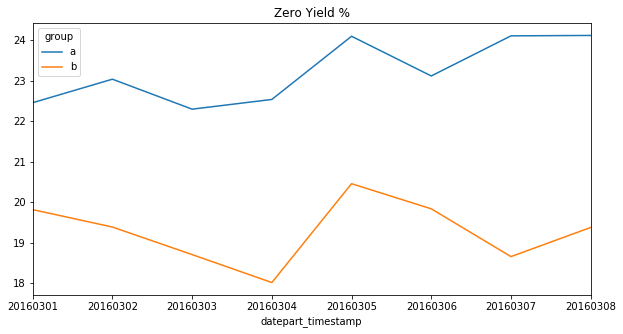

In [14]:
#Plotting the graph for zeroyield
result_ab.plot(kind='line',x='datepart_timestamp',y='zeroyield', title='Zero Yield %', figsize=(10,5))
plt.show()

In [15]:
#for finding the session lengths for each session
#creating a df with only checkin records
df_only_checkins = df.query('action=="checkin"')

#changing the datatype of checkin from object(string) to int as we have to perform addition on this
df_only_checkins['checkin'] = df_only_checkins['checkin'].astype(int)
df_only_checkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 223821 entries, 2 to 400164
Data columns (total 11 columns):
uuid                      223821 non-null object
timestamp                 223821 non-null object
session_id                223821 non-null object
group                     223821 non-null object
action                    223821 non-null object
checkin                   223821 non-null int64
page_id                   223821 non-null object
n_results                 0 non-null object
result_position           196401 non-null object
datepart_timestamp        223821 non-null object
datehourpart_timestamp    223821 non-null object
dtypes: int64(1), object(10)
memory usage: 20.5+ MB


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [16]:
#finding the max checkin value for each session (assuming a session can have multiple pages then getting multiple values)
df_max_checkins = df_only_checkins.groupby(['datehourpart_timestamp','session_id','page_id','group'])['checkin'].agg([('max_checkin','max')])
df_max_checkins.head()

max_checkin
datehourpart_timestamp session_id       page_id          group             
00                     001e2d0e159172d2 276f64347234cf85 b               10
                       00aebafc791cf00b c819a427eea3dceb a               30
                       014d59603fa1702d a76134ea0f5ac46e a              300
                       018d8768ab3e3b42 73334bb941fabf2d a              420
                                        922a6718c4754498 a               30

In [17]:
#adding all the session values to find session length for each group based on their hours of login
df_sum_checkins = df_max_checkins.groupby(['datehourpart_timestamp','group'])['max_checkin'].agg([('sum_checkin','sum')]).reset_index()
df_sum_checkins.head()

,datehourpart_timestamp,group,sum_checkin
0,00,a,108850
1,00,b,34620
2,01,a,109880
3,01,b,31300
4,02,a,101750


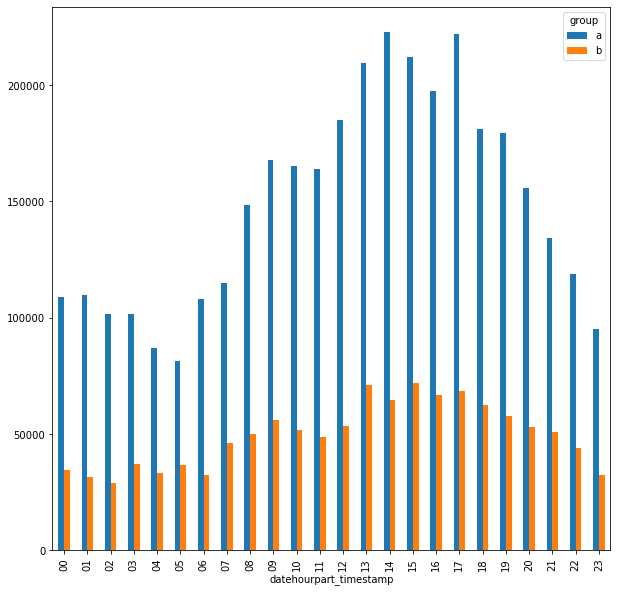

In [18]:
#plotting the session length against the hours in each people of different group login
result_session_length = df_sum_checkins.pivot(index='datehourpart_timestamp', columns='group', values=['sum_checkin']).reset_index()
result_session_length.plot(kind='bar',x='datehourpart_timestamp',y='sum_checkin', figsize=(10,10))
plt.show()